### Daytum Course: Spatial Data Analytics

### Variogram Modeling for Subsurface Data Analytics in Python 

Here's a simple workflow on detecting the major spatial continuity directions in a spatial dataset with variogram analysis. This information is essential to optimum well placement and prectiction away from wells.  First let's explain the concept of spatial continuity and the variogram.

#### Spatial Continuity 

**Spatial Continuity** is the correlation between values over distance.

* No spatial continuity – no correlation between values over distance, random values at each location in space regardless of separation distance.

* Homogenous phenomenon have perfect spatial continuity, since all values as the same (or very similar) they are correlated. 

We need a statistic to quantify spatial continuity! A convenient method is the Semivariogram.

#### The Semivariogram

Function of difference over distance.

* The expected (average) squared difference between values separated by a lag distance vector (distance and direction), $h$:

\begin{equation}
\gamma(\bf{h}) = \frac{1}{2 N(\bf{h})} \sum^{N(\bf{h})}_{\alpha=1} (z(\bf{u}_\alpha) - z(\bf{u}_\alpha + \bf{h}))^2  
\end{equation}

where $z(\bf{u}_\alpha)$ and $z(\bf{u}_\alpha + \bf{h})$ are the spatial sample values at tail and head locations of the lag vector respectively.

* Calculated over a suite of lag distances to obtain a continuous function.

* the $\frac{1}{2}$ term converts a variogram into a semivariogram, but in practice the term variogram is used instead of semivariogram.
* We prefer the semivariogram because it relates directly to the covariance function, $C_x(\bf{h})$ and univariate variance, $\sigma^2_x$:

\begin{equation}
C_x(\bf{h}) = \sigma^2_x - \gamma(\bf{h})
\end{equation}

Note the correlogram is related to the covariance function as:

\begin{equation}
\rho_x(\bf{h}) = \frac{C_x(\bf{h})}{\sigma^2_x}
\end{equation}

The correlogram provides of function of the $\bf{h}-\bf{h}$ scatter plot correlation vs. lag offset $\bf{h}$.  

\begin{equation}
-1.0 \le \rho_x(\bf{h}) \le 1.0
\end{equation}

#### Variogram Observations

The following are common observations for variograms that should assist with their practical use.

##### Observation \#1 - As distance increases, variability increase (in general).

This is common since in general, over greater distance offsets, there is often more difference between the head and tail samples.

In some cases, such as with spatial cyclicity of the hole effect variogram model the variogram may have negative slope over somelag distance intervals

Negative slopes at lag distances greater than half the data extent are often caused by too few pairs for a reliable variogram calculation

##### Observation \#2 - Calculated with over all possible pairs separated by lag vector, $\bf{𝐡}$.

We scan through the entire data set, searching for all possible pair combinations with all other data.  We then calculate the variogram as one half the expectation of squared difference between all pairs.

More pairs results in a more reliable measure.

##### Observation \#3 - Need to plot the sill to know the degree of correlation.

**Sill** is the variance, $\sigma^2_x$

Given stationarity of the variance, $\sigma^2_x$, and variogram $\gamma(\bf{h})$:

we can define the covariance function:

\begin{equation}
C_x(\bf{h}) = \sigma^2_x - \gamma(\bf{h})
\end{equation}

The covariance measure is a measure of similarity over distance (the mirror image of the variogram as shown by the equation above).

Given a standardized distribution $\sigma^2_x = 1.0$, the covariance, $C_x(\bf{h})$, is equal to the correlogram, $\rho_x(\bf{h})$: 

\begin{equation}
\rho_x(\bf{h}) = \sigma^2_x - \gamma(\bf{h})
\end{equation}

##### Observation \#4 - The lag distance at which the variogram reaches the sill is know as the range.

At the range, knowing the data value at the tail location provides no information about a value at the head location of the lag distance vector.

##### Observation \#5 - The nugget effect, a discontinuity at the origin

Sometimes there is a discontinuity in the variogram at distances less than the minimum data spacing.  This is known as **nugget effect**.

The ratio of nugget / sill, is known as relative nugget effect (%). Modeled as a discontinuity with no correlation structure that at lags, $h \gt \epsilon$, an infinitesimal lag distance, and perfect correlation at $\bf{h} = 0$.
Caution when including nuggect effect in the variogram model as measurement error, mixing populations cause apparent nugget effect

This exercise demonstrates the semivariogram calculation with GeostatsPy. The steps include:

1. generate a 2D model with sequential Gaussian simulation
2. sample from the simulation
3. calculate and visualize experimental semivariograms

#### Detecting Directions of Continuity

Spatial continuity can be described with nested spatial continuity models:

\begin{equation}
\Gamma_x(\bf{h}) = \sum_{i=1}^{nst} \gamma_i(\bf{h})
\end{equation}

where $\Gamma_x(\bf{h})$ is the nested variogram model resulting from the summation of $nst$ nested variograms  $\gamma_i(\bf{h})$.

Each one of these variogram structures, $\gamma_i(\bf{h})$, is based on a geometric anisotropy model parameterized by the orientation and range in the major and minor directions.  In 2D this is simply an azimuth and ranges, $azi$, $a_{maj}$ and $a_{min}$. Note, the range in the minor direction (orthogonal to the major direction.

The geometric anisotropy model assumes that the range in all off-diagonal directions is based on an ellipse with the major and minor axes alligned with and set to the major and minor for the variogram.

\begin{equation}
\bf{h}_i = \sqrt{\left(\frac{r_{maj}}{a_{maj_i}}\right)^2 + \left(\frac{r_{maj}}{a_{maj_i}}\right)^2}  
\end{equation}

Therefore, if we know the major direction, range in major and minor directions, we may completely describe each nested componnent of the complete spatial continuity of the variable of interest, $i = 1,\dots,nst$.

In this workflow we will explore methods to detect directionality from a spatial dataset.

#### Load the required libraries

The following code loads the required libraries.

In [6]:
import geostatspy.GSLIB as GSLIB                       # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats                 # GSLIB methods convert to Python    

We will also need some standard packages. These should have been installed with Anaconda 3.

In [7]:
import os                                               # to set current working directory 
import numpy as np                                      # arrays and matrix math
import pandas as pd                                     # DataFrames
import matplotlib.pyplot as plt                         # plotting
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
import warnings
warnings.filterwarnings('ignore')
cmap = plt.cm.inferno

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Define Functions

This is a convenience function to add major and minor gridlines to improve plot interpretability.

In [8]:
def add_grid():                                          
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks   


#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time).  Also, in this case make sure to place the required (see above) GSLIB executables in this directory or a location identified in the environmental variable *Path*.

In [9]:
#os.chdir("d:/PGE383")                                   # set the working directory

#### Loading Tabular Data

Here's the command to load the data into a Pandas' DataFrame object. You can select one of the following datasets with command,

````python 
idata = 0
````

| Index       | Name             | Description                                                  |
|:-----------:|:------------------:|:--------------------------------------------------------------:|
| 0           | sample_data_biased | biased with moderate covered and one section dense, regular sampling | 
| 1           | spatial_nonlinear_MV_facies_v1 | biased with dense sampling | 
| 2           | spatial_nonlinear_MV_facies_v5_sand_only | NOT AVAILBLE FOR THIS EXERCISE |
| 3           | 12_sample_data.csv | biased sparsely sampled | 
| 4           | sample_data.csv | regular sampling 2 densely sampled study areas | 

In [33]:
idata = 0

if idata == 0:
    df = pd.read_csv(r'https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/sample_data_biased.csv') # load the data from Dr. Pyrcz's github repository
    pormax = 0.24
if idata == 1:
    df = pd.read_csv(r'https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/spatial_nonlinear_MV_facies_v1.csv') # load the data from Dr. Pyrcz's github repository
    df = df.rename(columns={'Por': 'Porosity'})  
    df['Porosity'] = df['Porosity']/100.0
    pormax = 0.24
if idata == 2:
    print("Dataset 2 is not used in this demonstration (only sand facies)")
if idata == 3:    
    df = pd.read_csv(r'https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/12_sample_data.csv') # load the data from Dr. Pyrcz's github repository
    df = df.rename(columns={'Por': 'Porosity'})  
    df = df.sample(n = 40)
    pormax = 0.30
if idata == 4:    
    df = pd.read_csv(r'https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/sample_data.csv') # load the data from Dr. Pyrcz's github repository
    df = df.rename(columns={'Por': 'Porosity'})  
    pormax = 0.30

For brevity we will work with all facies combined.

In [34]:
df.head()                                              # preview the sand only DataFrame

,X,Y,Facies,Porosity,Perm
0,100,900,1,0.115359,5.736104
1,100,800,1,0.136425,17.211462
2,100,600,1,0.135810,43.724752
3,100,500,0,0.094414,1.609942
4,100,100,0,0.113049,10.886001


#### Summary Statistics for Tabular Data

Let's look at summary statistics for all facies combined:

In [35]:
df.describe().transpose()                          # summary table of sand only DataFrame statistics

,count,mean,std,min,25%,50%,75%,max
X,289.0,475.813149,254.277530,0.000000,300.000000,430.000000,670.000000,990.000000
Y,289.0,529.692042,300.895374,9.000000,269.000000,549.000000,819.000000,999.000000
Facies,289.0,0.813149,0.390468,0.000000,1.000000,1.000000,1.000000,1.000000
Porosity,289.0,0.134744,0.037745,0.058548,0.106318,0.126167,0.154220,0.228790
Perm,289.0,207.832368,559.359350,0.075819,3.634086,14.908970,71.454424,5308.842566


Let's transform the porosity and permeaiblity data to standard normal (mean = 0.0, standard deviation = 1.0, Gaussian shape). This is required for sequential Gaussian simulation (common target for our variogram models) and the Gaussian transform assists with outliers and provides more interpretable variograms. 

Let's look at the inputs for the GeostatsPy nscore program.  Note the output include an ndarray with the transformed values (in the same order as the input data in Dataframe 'df' and column 'vcol'), and the transformation table in original values and also in normal score values. 

In [36]:
geostats.nscore                                         # see the input parameters required by the nscore function

<function geostatspy.geostats.nscore(df, vcol, wcol=None, ismooth=False, dfsmooth=None, smcol=0, smwcol=0)>

The following command will transform the Porosity and Permeabilty to standard normal. 

In [37]:
#Transform to Gaussian by Facies
df['NPor'], tvPor, tnsPor = geostats.nscore(df, 'Porosity') # nscore transform for all facies porosity 
df['NPerm'], tvPermSand, tnsPermSand = geostats.nscore(df, 'Perm')  # nscore transform for all facies permeability

Let's look at the updated DataFrame to make sure that we now have the normal score porosity and permeability.

In [38]:
df.head()                                               # preview sand DataFrame with nscore transforms

,X,Y,Facies,Porosity,Perm,NPor,NPerm
0,100,900,1,0.115359,5.736104,-0.391400,-0.429142
1,100,800,1,0.136425,17.211462,0.299307,0.112995
2,100,600,1,0.135810,43.724752,0.272201,0.556521
3,100,500,0,0.094414,1.609942,-1.269810,-1.178106
4,100,100,0,0.113049,10.886001,-0.496733,-0.156762


That looks good! One way to check is to see if the relative magnitudes of the normal score transformed values match the original values.  e.g. that the normal score transform of 0.10 porosity normal score is less than the normal score transform of 0.14 porsity.  Also, the normal score transform of values close to the mean value should be close to 0.0 

Let's also check the original and transformed sand and shale porosity distributions.

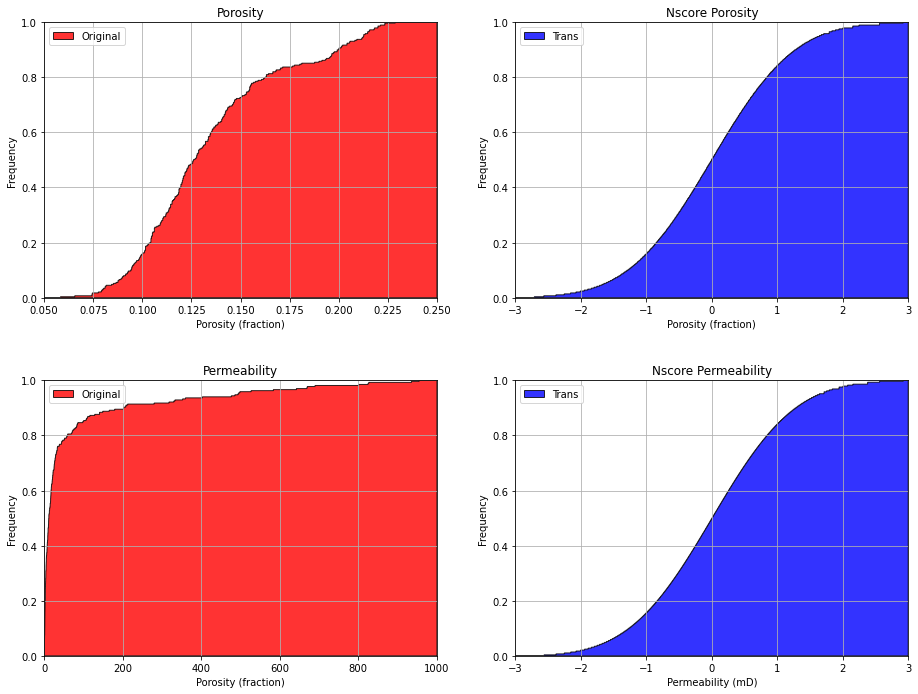

In [39]:
plt.subplot(221)                                        # plot original sand and shale porosity histograms
plt.hist(df['Porosity'], facecolor='red',bins=np.linspace(0.0,0.25,1000),histtype="stepfilled",alpha=0.8,
         density=True,cumulative=True,edgecolor='black',label='Original')
plt.xlim([0.05,0.25]); plt.ylim([0,1.0])
plt.xlabel('Porosity (fraction)'); plt.ylabel('Frequency'); plt.title('Porosity')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(222)  
plt.hist(df['NPor'], facecolor='blue',bins=np.linspace(-3.0,3.0,1000),histtype="stepfilled",alpha=0.8,
         density=True,cumulative=True,edgecolor='black',label = 'Trans')
plt.xlim([-3.0,3.0]); plt.ylim([0,1.0])
plt.xlabel('Porosity (fraction)'); plt.ylabel('Frequency'); plt.title('Nscore Porosity')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(223)                                        # plot nscore transformed sand and shale histograms
plt.hist(df['Perm'], facecolor='red',bins=np.linspace(0.0,1000.0,100000),histtype="stepfilled",alpha=0.8,
         density=True,cumulative=True,edgecolor='black',label='Original')
plt.xlim([0.0,1000.0]); plt.ylim([0,1.0])
plt.xlabel('Porosity (fraction)'); plt.ylabel('Frequency'); plt.title('Permeability')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(224)                                        # plot nscore transformed sand and shale histograms
plt.hist(df['NPerm'], facecolor='blue',bins=np.linspace(-3.0,3.0,100000),histtype="stepfilled",alpha=0.8,
         density=True,cumulative=True,edgecolor='black',label = 'Trans')
plt.xlim([-3.0,3.0]); plt.ylim([0,1.0])
plt.xlabel('Permeability (mD)'); plt.ylabel('Frequency'); plt.title('Nscore Permeability')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.2, hspace=0.3)
plt.show()

The normal score transform has correctly transformed the porosity and permeability to standard normal.

#### Method \#1: Ocular Inspection of Posted Data

Data visualization is very useful to detect patterns. Our brains are very good at pattern detection. I promote quantitative methods and recognize issues with cognitive bias, but it is important to recognize the value is expert intepretation based on data visualization.

* This data visualization will also be important to assist with parameter selection for the quantitative methods later.

Let's plot the location maps of normal score transforms of porosity and permeability for all facies. We will also include a cross plot of the nscore permeability vs. porosity colored by facies to aid with comparison in spatial features between the porosity and permeability data.

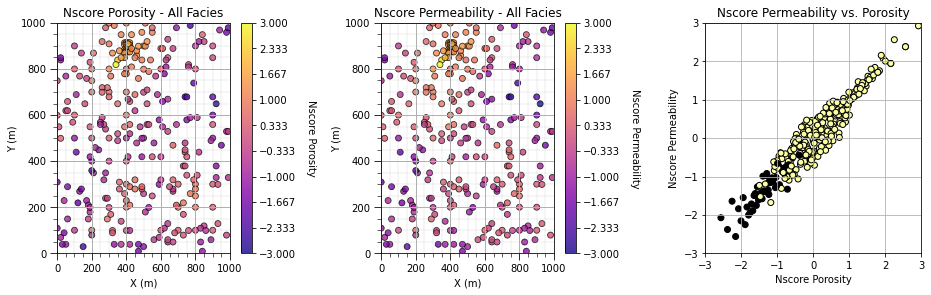

In [40]:
cmap = plt.cm.plasma                    # color map
plt.subplot(131)
GSLIB.locmap_st(df,'X','Y','NPor',0,1000,0,1000,-3,3,'Nscore Porosity - All Facies','X (m)','Y (m)',
                'Nscore Porosity',cmap)
add_grid()

plt.subplot(132)
GSLIB.locmap_st(df,'X','Y','NPerm',0,1000,0,1000,-3,3,'Nscore Permeability - All Facies','X (m)','Y (m)',
                'Nscore Permeability',cmap)
add_grid()

plt.subplot(133)
facies = df['Facies'].values +0.01
plt.scatter(df['NPor'],df['NPerm'],c = facies,edgecolor = 'black',cmap = plt.cm.inferno)
#plt.plot([-3,3],[-3,3],color = 'black')
plt.xlabel(r'Nscore Porosity')
plt.ylabel(r'Nscore Permeability')
plt.title('Nscore Permeability vs. Porosity')
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.8, wspace=0.5, hspace=0.3); plt.show()

What do you see?  Here's my observations:

* there is a high degree of spatial agreement between porosity and permeability, this is supported by the high correlation evident in the cross plot.
* there are no discontinuities that could suggest that facies represent a distinct change, rather the porosity and permeability seem continuous and the assigned facies are a truncation of their continous behavoir, we doing 'ok' with no facies
* suspect a 045 azimuth major direction of continuity (up - right)
* there may be cycles in the 135 azimuth 
* there will not likely be a nugget effect, but there is an hint of some short scale discontinuity?

**Do you agree?** If you have a different observations, drop me a line at mpyrcz@austin.utexas.edu and I'll add to this lesson with credit.

#### Method \#2: Variogram Maps

Let's try out variogram maps. 

* I realized that I had not coded variogram maps in Python, so I just did it and added it to GeostatsPy.  I have added if here temporarily to support my students completely their assignments. I'm teaching this week at a company and it is safer not to update the package until I have time to test it.

The inputs include: 

* **input data** - DataFrame, 'df', and columns for x, y and property of interest, 'x', 'y' and 'vcol', 
* **variogram map parameters** - number of cells in each direction to search, 'nxlag', nylag', the cell size / lag distance, 'dxlag' and 'dylag'''
* **search** - the minimum number of pairs reuqired to assign a result, 'mnpairs'
* **normalization** - 1 for standardize variance to 1.0 and 0 for not

The output is a 2D ndarray with the variogram map and the number of pairs.

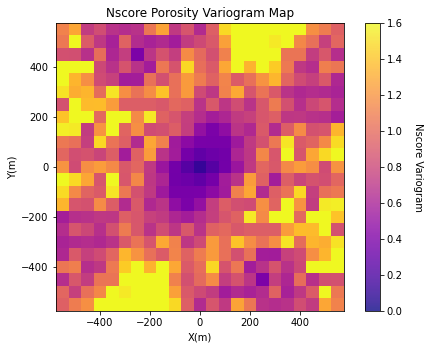

The shape of the output is (23, 23)


In [41]:
vmap, npmap = geostats.varmapv(df,'X','Y','NPor',tmin=-999,tmax=999,nxlag=11,nylag=11,dxlag=50,dylag=50,minnp=1,isill=1)

plt.subplot(111)
GSLIB.pixelplt_st(vmap,-575,575,-575,575,50.0,0,1.6,'Nscore Porosity Variogram Map','X(m)','Y(m)','Nscore Variogram',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.2, hspace=0.2); plt.show()

print('The shape of the output is ' + str(vmap.shape))

Notice that the output ndarray is 23, 23 cells? We asked for the number of cells to extend in each direction, 11 and 11 in x and y.  The map has an origin (zero distance) cell in the middle and extends 11 in both positive and negative directions.  So we have 2*$nx$ + 1, 2*$ny$ + 1 cells in the resulting variogram map and the $xmin = -1 * (nx * x_{cellsize} + \frac{1}{2} x_{cellsize})$ and the $xmax = nx * x_{cellsize} + \frac{1}{2} x_{cellsize}$

What do you think of this variogram map? These are my observations:

* major continuity direction is at azimuth 045
* there is a high degree of geometric anisotropy
* there is cyclicity in the 135 direction 
* there may be some cyclicity in the 045 direction

From this variogram map we can immediately see directionality in our spatial data.

#### Method \#3: Experimental Variograms

Another method for exploring spatial data directionality is the calculation of multiple experimental variograms for a variety of directions.

We can use the location maps to help determine good variogram calculation parameters.

```p
tmin = -9999.; tmax = 9999.; 
lag_dist = 100.0; lag_tol = 50.0; nlag = 7; bandh = 9999.9; azi = azi; atol = 22.5; isill = 1
```
* **tmin**, **tmax** are trimming limits - set to have no impact, no need to filter the data
* **lag_dist**, **lag_tol** are the lag distance, lag tolerance - set based on the common data spacing (100m) and tolerance as 100% of lag distance for additonal smoothing
* **nlag** is number of lags - set to extend just past 50 of the data extent
* **bandh** is the horizontal band width - set to have no effect
* **azi** is the azimuth -  it has not effect since we set atol, the azimuth tolerance, to 90.0
* **isill** is a boolean to standardize the distribution to a variance of 1 - it has no effect since the nscore transform sets the variance to 1.0

In [42]:
tmin = -9999.; tmax = 9999.                             # no trimming 
lag_dist = 100.0; lag_tol = 100.0; nlag = 7;            # maximum lag is 700m and tolerance > 1/2 lag distance for smoothing
bandh = 9999.9; atol = 22.5                             # no bandwidth, directional variograms
isill = 1                                               # standardize sill
azi_mat = [0,22.5,45,67.5,90,112.5,135,157.5]           # directions in azimuth to consider

Let's try running these variograms and visualizing them on separate plots.  I'll demonstrate a method to promgramtically loop over each direction for efficiency (and code brevity).

* we have the direction in the list called 'azi_mat'
* we use the command:
```p
for iazi in range(0,len(azi_mat)): 
```
to loop over all the elements in the list with index 'iazi'

* we run the variogram calculation and store the reuslts in 2D arrays, iy is direction, ix is the lag
* we use subplots with the 'iazi' index to add each plot

```p
    plt.subplot(4,2,iazi+1)
```
we add one because the plot index must be $1,\ldots,n$, but arrays / list index as $0,\ldots,n-1$ in Python.

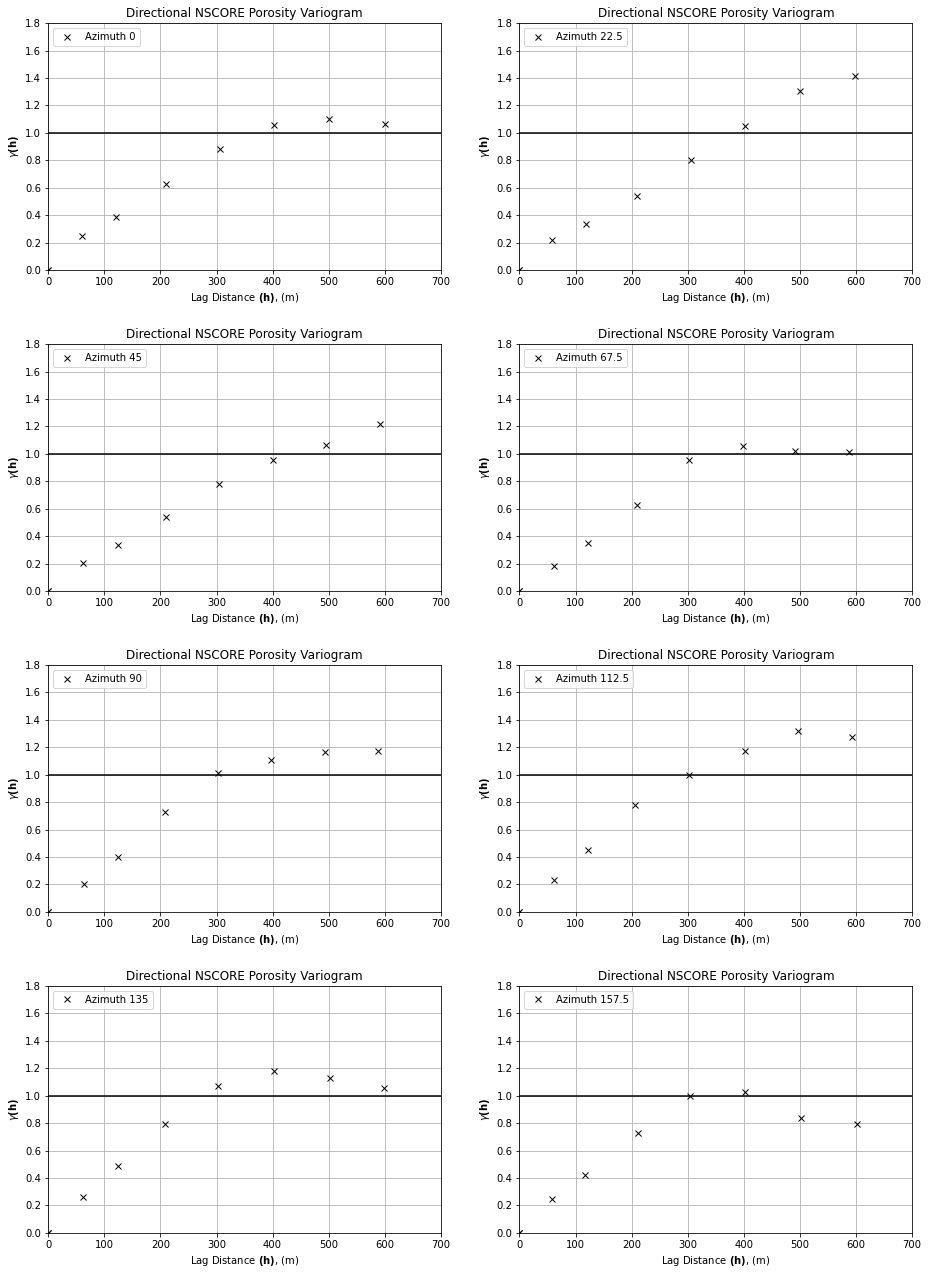

In [43]:
# Arrays to store the results
lag = np.zeros((len(azi_mat),nlag+2)); gamma = np.zeros((len(azi_mat),nlag+2)); npp = np.zeros((len(azi_mat),nlag+2));

for iazi in range(0,len(azi_mat)):                      # Loop over all directions
    lag[iazi,:], gamma[iazi,:], npp[iazi,:] = geostats.gamv(df,"X","Y","NPor",tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[iazi],atol,bandh,isill)
    plt.subplot(4,2,iazi+1)
    plt.plot(lag[iazi,:],gamma[iazi,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[iazi]))
    plt.plot([0,2000],[1.0,1.0],color = 'black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Directional NSCORE Porosity Variogram')
    plt.xlim([0,700])
    plt.ylim([0,1.8])
    plt.legend(loc='upper left')
    plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=4.2, wspace=0.2, hspace=0.3); plt.show()

The directional variograms provide a very clear image of directionality. The ranges vary from 300m, 500m to zonal anisotropy, to 500m, 350m, 280m, 250m and finally 280m.  We are observing the actually spatial continuity ellipse by exploring a variety of directions! 

* We can observe that Azimuth 045 is the major direction and Azimuth 135 is the minor direction.

This is a very powerful tool for exploring directionality in spatial datasets.

#### Variogram Modeling

From above we can identify 045 as the major direction and 135 as the minor direction. We must build a single 2D nested variogram model based on the experiential variograms in each 045 and 135 directions.  First, let's look at these two experimental variograms again.

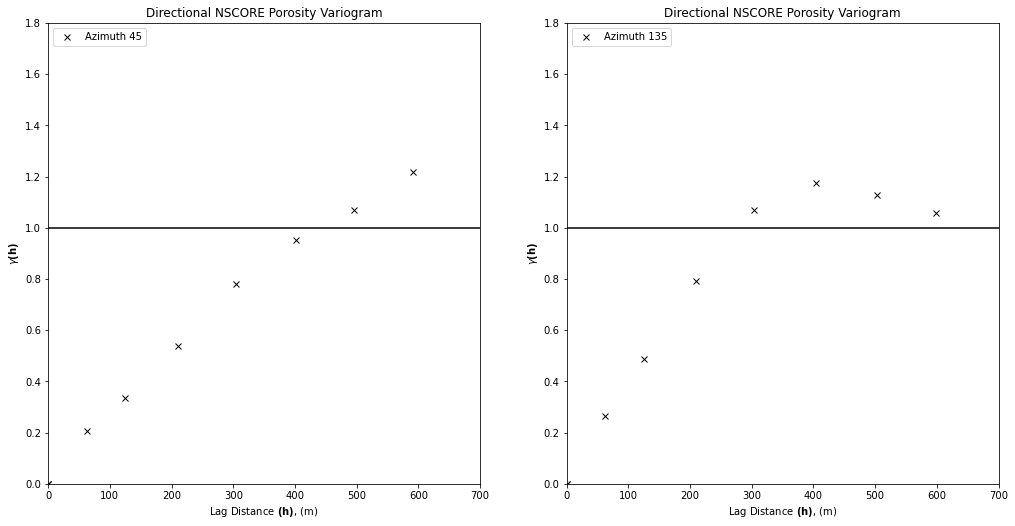

In [44]:
plt.subplot(1,2,1)
plt.plot(lag[2,:],gamma[2,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[2]))
plt.plot([0,2000],[1.0,1.0],color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional NSCORE Porosity Variogram')
plt.xlim([0,700])
plt.ylim([0,1.8])
plt.legend(loc='upper left')

plt.subplot(1,2,2)
plt.plot(lag[6,:],gamma[6,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[6]))
plt.plot([0,2000],[1.0,1.0],color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional NSCORE Porosity Variogram')
plt.xlim([0,700])
plt.ylim([0,1.8])
plt.legend(loc='upper left')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.6, wspace=0.2, hspace=0.3)
plt.show()

We will assume these models will be applied in sequential Gaussian simulation; therefore, we must model to the sill (or the global distribution will not be reproduced over the realizations).  We will also not use cyclicity for now, as we are just getting started.  

* Let's build a reasonable model to the sill.

##### make_variogram function

We use the make_variogram function to make a variogram model 

* a dictionary for compact storage of the variogram model parameters to pass into plotting (below), kriging and simulation methods 

The variogram model parameter include:

* **nug** - nugget effect contribution to sill
* **nst** - number of nested structures (1 or 2)
* **it** - type for this nested structure (1 - spherical, 2 - exponential, 3 - Gaussian)
* **cc** - contribution of each nested structure (contributions + nugget must sum to the sill)
* **azi** - the azimuth for this nested structure of the major direction, the minor is orthogonal
* **hmaj** - the range for this nested structure in the major direction
* **hmin** - the range for this nested structure in the minor direction

We increment it, cc, azi, hmaj, and hmin for the 1st and 2nd structures

* for only 1 structure plus optional nugget, omit the 2nd structure parameters and they will default to $cc2 = 0$, no contribution to the model

Here's my model:

```p
nug = 0.0; nst = 2
it1 = 1; cc1 = 0.6; azi1 = 45; hmaj1 = 350; hmin1 = 350                # first structure
it2 = 1; cc2 = 0.4; azi2 = 45; hmaj2 = 9999.9; hmin2 = 400             # second structure
```

Some comments on our model:

* we model to the sill of 1.0, since we applied the normal score transform ($nug + cc1 + cc2 = 1.0$)

* we used 2 spherical structures to capture zontal anisotropy in the 045 azimuth

* since the experimental variogram exceeds the sill with trend or cyclicity we could have attempted trend modeling and then worked with the residual, but we will not do this for workflow brevity and simplicity

We input these model parameters to make a variogram model dictionary with the make_variogram function as follows:

```p
vario = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2,cc2,azi2,hmaj2,hmin2)
```

##### vmodel function

To plot the variogram we use the vmodel function to project the model in the major and minor directions

The inputs for vmodel are:

* **nlag** - the number of points along the variogram to calculate for the projection

* **xlag** - the size of a lag for the projection

* **azm** - the direction of the projection in azimuth (this is all we need since we are working in 2D)

* **vario** - the variogram model dictionary from the make_variogram function (above)

Note: this function is just for visualization by projecting the variogram model in a direction, so the convention is to use a very small **xlag** and large **nlag** for a high resolution display of the variogram model

The outputs from the vmodel program include:

* **index** - the lag number for the projection

* **lag distance** - the distance offset along the projection (the **h** in the variogram plot)

* **variogram** - the variogram value at the lag distance for the projection (the $\gamma$(**h**) in the variogram plot)

* **covariance function** - the covariance function at the lag distance for the projection (for the C(**h**) plot)

* **correlogram** - the correlogram at the lag distance for the projection (for the $\rho$(**h**) plot)

We have 2 structures and no nugget effect.  We needed the 2nd structure to capture the zonal anisotropy in the 045 direction.  Let's calculate the variogram model in these directions and plot them with the experimental variograms.   

 x,y,z offsets = 7.071067805519558,7.071067818211393
 x,y,z offsets = 7.071067830903227,-7.071067792827723


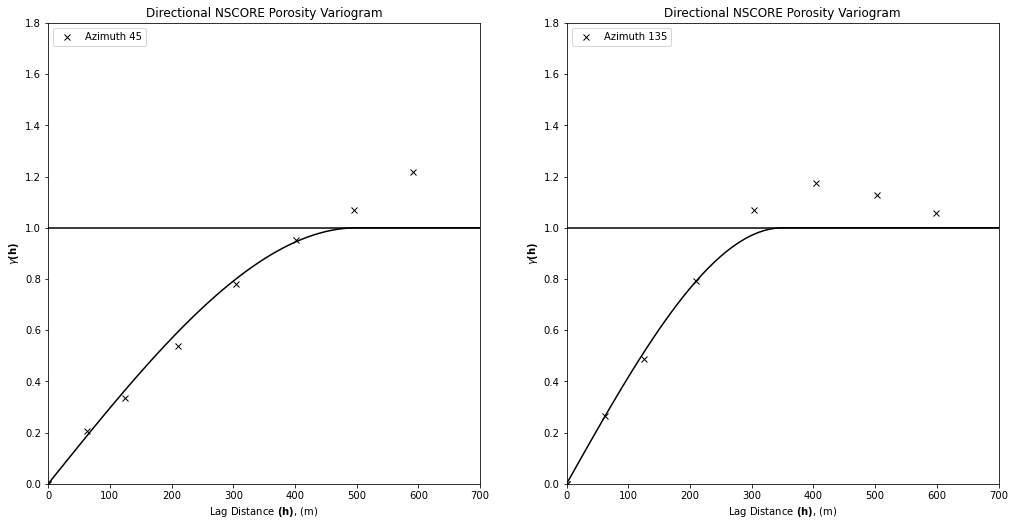

In [45]:
nug = 0.0; nst = 1                                             # 2 nest structure variogram model parameters
it1 = 1; cc1 = 1.0; azi1 = 45; hmaj1 = 500; hmin1 = 350
it2 = 1; cc2 = 0.0; azi2 = 45; hmaj2 = 9999.9; hmin2 = 400

vario = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2,cc2,azi2,hmaj2,hmin2) # make model object
nlag = 70; xlag = 10; azm = 45;                                # project the model in the 045 azimuth
index45,h45,gam45,cov45,ro45 = geostats.vmodel(nlag,xlag,azm,vario)
azm = 135                                                      # project the model in the 135 azimuth
index135,h135,gam135,cov135,ro135 = geostats.vmodel(nlag,xlag,azm,vario)

plt.subplot(1,2,1)
plt.plot(lag[2,:],gamma[2,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[2]))
plt.plot([0,2000],[1.0,1.0],color = 'black')
plt.plot(h45,gam45,color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional NSCORE Porosity Variogram')
plt.xlim([0,700])
plt.ylim([0,1.8])
plt.legend(loc='upper left')

plt.subplot(1,2,2)
plt.plot(lag[6,:],gamma[6,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[6]))
plt.plot([0,2000],[1.0,1.0],color = 'black')
plt.plot(h135,gam135,color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional NSCORE Porosity Variogram')
plt.xlim([0,700])
plt.ylim([0,1.8])
plt.legend(loc='upper left')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.6, wspace=0.2, hspace=0.3)
plt.show()

#### Comments

This was a basic demonstration of vairogram modeling for spatial continuity analysis. Much more could be done, I have other demonstrations on the basics of working with DataFrames, ndarrays, univariate statistics, plotting data, declustering, data transformations and many other workflows available at https://github.com/GeostatsGuy/PythonNumericalDemos and https://github.com/GeostatsGuy/GeostatsPy. 
  
#### The Author:

### Michael Pyrcz, Professor, The University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

<i>&copy; Copyright daytum 2021. All Rights Reserved</i>